Trying out the Transformer dataset class from Pylearn2 with our current dataset class as raw, should be able to make a block to apply to it using one of our processing functions that will produce a random combination of it's processing functions.

Setting up
====

Loading the data and the model, the classic loosely AlexNet based model we've been using for a while.

In [1]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


In [3]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/alexnet_based.json", settings, force=True)

In [4]:
# loading the model
model = pylearn2.utils.serial.load(run_settings['pickle abspath'])
# loading the data
dataset = neukrill_net.dense_dataset.DensePNGDataset(settings_path=run_settings['settings_path'],
                                            run_settings=run_settings['run_settings_path'],
                                                     train_or_predict='train',
                                                     training_set_mode='validation', force=True)

(3026,)


Making a Block
=====

Pylearn2 uses [Blocks to apply the processing functions to the raw data][blockexample]. The Transformer class appears to be able to also take [model pickle files as transforms][ae]. Hopefully, we can just make an object that inherits the Block base class and supply it with a function to transform an image and that might work. The documentation doesn't really say one way or the other.

[blockexample]: https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/scripts/tutorials/deep_trainer/run_deep_trainer.py
[ae]: http://nbviewer.ipython.org/github/lisa-lab/pylearn2/blob/master/pylearn2/scripts/tutorials/stacked_autoencoders/stacked_autoencoders.ipynb

In [5]:
import pylearn2.blocks
import neukrill_net.image_processing

In [6]:
b = pylearn2.blocks.Block()

In [7]:
b.fn = lambda x: neukrill_net.image_processing.flip_image(x,flip_x=True)

In [8]:
t = dataset.get_topological_view(dataset.X[:1,:])

In [9]:
t.shape

(1, 48, 48, 1)

Image.Image   (z)
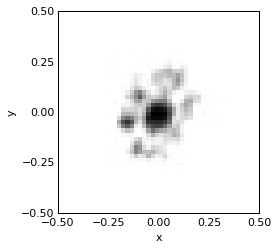

In [10]:
%opts Image style(cmap='gray')
i = hl.Image(t.reshape(t.shape[1:3]))
i

In [11]:
import pdb

In [12]:
class SampleAugment(pylearn2.blocks.Block):
    def __init__(self,fn,target_shape):
        self._fn = fn
        self.cpu_only=False
        self.target_shape = target_shape
    def __call__(self,inputs):
        return self.fn(inputs)
    def fn(self,inputs):
        # prepare empty array same size as inputs
        req = inputs.shape
        sh = [inputs.shape[0]] + list(self.target_shape)
        inputs = inputs.reshape(sh)
        processed = np.zeros(sh)
        # hand each image as a 2D array
        for i in range(inputs.shape[0]):
            processed[i] = self._fn(inputs[i].reshape(self.target_shape))
        processed = processed.reshape(req)
        return processed

In [13]:
b = SampleAugment(lambda x: neukrill_net.image_processing.flip_image(x,flip_x=True),(48,48))

Image.Image   (z)
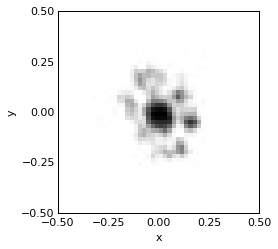

In [14]:
hl.Image(b(t).reshape(t.shape[1:3]))

So it flips images like it's supposed to. Now we can try to make a TransformerDataset using it:

In [15]:
# want to make sure the processing is obvious
b = SampleAugment(lambda x: np.zeros(x.shape),(48,48))

In [16]:
import pylearn2.datasets.transformer_dataset

In [17]:
tdataset = pylearn2.datasets.transformer_dataset.TransformerDataset(dataset,b,
                                                                    space_preserving=True)

Image.Image   (z)
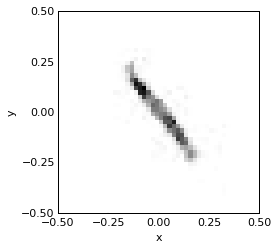

In [18]:
hl.Image(dataset.get_batch_topo(1).reshape(t.shape[1:3]))

Image.Image   (z)
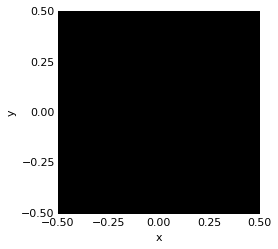

In [19]:
hl.Image(tdataset.get_batch_topo(1).reshape(t.shape[1:3]))

Should be possible to hack together from here. Making a transformer dataset that takes a stochastic processing function in a block; sampling from a set of possible augmentations and applying them to the image.

Stupid Transformer
======

The stupid transformer takes a dataset after preprocessing; after the dataset has been resized and normalised into a homogeneous numpy array. It then applies its processing function to each of the examples in the array when a batch is requested.

This is pretty easy to make; in fact we've pretty much done it above. All we need is a stochastic augmentation function that will apply a random augmentation to the images supplied each time. Then, we'll have a potentially massive dataset.

In [20]:
import neukrill_net.augment

In [21]:
reload(neukrill_net.augment)

<module 'neukrill_net.augment' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/augment.pyc'>

In [22]:
import neukrill_net.blocks
reload(neukrill_net.blocks)

<module 'neukrill_net.blocks' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/blocks.pyc'>

In [23]:
fn = neukrill_net.augment.RandomAugment(**{"units":"float64",
                                           "rotate":-1,
                                           "flip":1,
                                           "rotate_is_resizable":0,
                                           "shear":[0,np.pi/4,np.pi/2],
                                           "crop":[0.05,0.1,0.2],
                                           "noise":0.001,
                                           "scale":[0.9,1.0,1.1,1.5],
                                           "resize":(48,48)
                                           })

In [24]:
t.squeeze().shape

(48, 48)

Image.Image   (z)
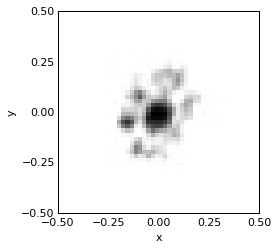

In [25]:
hl.Image(t.squeeze())

Image.Image   (z)
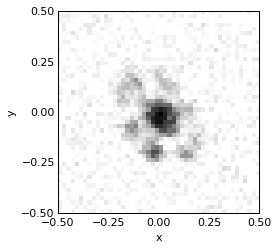

In [26]:
hl.Image(fn(t.squeeze()))

In [27]:
b = neukrill_net.blocks.SampleAugment(lambda x: fn(x),(48,48),(48,48))

In [28]:
tdataset = pylearn2.datasets.transformer_dataset.TransformerDataset(raw=dataset,transformer=b,
                                                                   space_preserving=True)

In [29]:
reload(neukrill_net.image_processing)

<module 'neukrill_net.image_processing' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/image_processing.pyc'>

In [30]:
tdataset.get_batch_topo(2).shape

(2, 48, 48, 1)

Image.Image   (z)
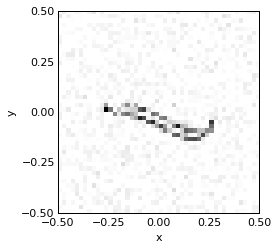

In [31]:
hl.Image(tdataset.get_batch_topo(1).reshape((48,48)))

In [32]:
tdataset.get_num_examples()

3026

In [33]:
batch_size = 128
num_batches = int(tdataset.get_num_examples()/batch_size)

Had to make some modifications to the Pylearn2 code to make this work:

In [34]:
import pylearn2.utils.iteration
reload(pylearn2.utils.iteration)

<module 'pylearn2.utils.iteration' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/pylearn2/pylearn2/utils/iteration.pyc'>

Iterator gets called during the SGD train loop, specifically on lines 445-464 in `pylearn2/training_algorithms/sgd.py`:

```python
        iterator = dataset.iterator(mode=self.train_iteration_mode,
                                    batch_size=self.batch_size,
                                    data_specs=flat_data_specs,
                                    return_tuple=True, rng=rng,
                                    num_batches=self.batches_per_iter)

        on_load_batch = self.on_load_batch
        for batch in iterator:
            for callback in on_load_batch:
                callback(*batch)
            self.sgd_update(*batch)
            # iterator might return a smaller batch if dataset size
            # isn't divisible by batch_size
            # Note: if data_specs[0] is a NullSpace, there is no way to know
            # how many examples would actually have been in the batch,
            # since it was empty, so actual_batch_size would be reported as 0.
            actual_batch_size = flat_data_specs[0].np_batch_size(batch)
            self.monitor.report_batch(actual_batch_size)
            for callback in self.update_callbacks:
                callback(self)
```

So we have to call the iterator the same way, specifically getting whatever `flat_data_specs` right.

In [35]:
from pylearn2.space import CompositeSpace

In [36]:
from pylearn2.utils.data_specs import DataSpecsMapping

In [37]:
data_specs = (model.get_input_space(),model.get_input_source())

In [38]:
mapping = DataSpecsMapping(data_specs)

In [39]:
space_tuple = mapping.flatten(data_specs[0], return_tuple=True)
source_tuple =  mapping.flatten(data_specs[1], return_tuple=True)

In [40]:
flat_data_specs = (CompositeSpace(space_tuple), source_tuple)

In [41]:
iterator = tdataset.iterator(mode='random_slice', data_specs=flat_data_specs,
                             batch_size=batch_size,num_batches=num_batches)

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/pylearn2/pylearn2/utils/iteration.py:783: UserWarning: dataset is using the old iterator interface which is deprecated and will become officially unsupported as of July 28, 2015. The dataset should implement a `get` method respecting the new interface.
  warnings.warn("dataset is using the old iterator interface which "


In [42]:
%pdb

Automatic pdb calling has been turned ON


In [43]:
iterator.next().shape

(1, 48, 48, 128)

So the iterators can't actually produce examples? In that case, what is it actually training on? Maybe it's failing over to the raw iterator silently? Would explain the lack of difference in actual performance.

In [44]:
iterator.raw_iterator.next().shape

(1, 48, 48, 128)

In [45]:
iterator.num_examples

2944

Smart Transformer
======

The big problem with the dataset before is that these transformations have to occur _after_ resizing, normalisation and loading all the images into this big numpy array. We might be able to hack our way round this by loading the images unprocessed into a very large numpy array and padding the spare area around most of the images with an indicator number; then shaving this off before augmentation and homogenisation back down to whatever size we're aiming for.

It would be much better if the transformer dataset had a stochastic function which it applied whenever it needed a batch to a set of _raw images_ held in memory. To make this, first going to try to create a dummy raw dataset that simply loads the raw images as a list of numpy arrays and supports the expected interface that the Transformer class will be looking for. Then, we just need to initialise our Block class with a processing function that can support processing from raw images.

In [46]:
import pylearn2.datasets

In [47]:
# don't have to think too hard about how to write this:
# https://stackoverflow.com/questions/19151/build-a-basic-python-iterator
class FlyIterator(object):
    """
    Simple iterator class to take a dataset and iterate over
    it's contents applying a processing function. Assuming
    the dataset has a processing function to apply.
    
    It may have an issue of there being some leftover examples
    that will never be shown on any epoch. Can avoid this by
    seeding with sampled numbers from the dataset's own rng.
    """
    def __init__(self, dataset, batch_size, num_batches,
                 final_shape, seed=42):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.final_shape = final_shape
        # initialise rng
        self.rng = np.random.RandomState(seed=seed)
        # shuffle indices of size equal to number of examples
        # in dataset
        N = self.dataset.get_num_examples()
        self.indices = range(N)
        self.rng.shuffle(self.indices)
        
    def __iter__(self):
        return self
    
    def next(self):
        # return one batch
        batch_indices = [self.indices.pop() for i in range(batch_size)]
        # preallocate array
        if len(self.final_shape) == 2: 
            batch = np.zeros([batch_size]+list(self.final_shape)+[1])
        elif len(self.final_shape) == 3:
            batch = np.zeros([batch_size]+list(self.final_shape))
        # iterate over indices, applying the dataset's processing function
        for i,j in enumerate(batch_indices):
            batch[i] = self.dataset.fn(self.dataset.X[j]).reshape(batch.shape[1:])
        return batch

In [48]:
class ListDataset(pylearn2.datasets.dataset.Dataset):
    """
    Loads images as raw numpy arrays in a list, tries 
    its best to respect the interface expected of a 
    Pylearn2 Dataset.
    """
    def __init__(self, transformer, settings_path="settings.json", 
                 run_settings_path="run_settings/alexnet_based.json",
                 verbose=False, force=False, seed=42):
        """
        Loads the images as a list of differently shaped
        numpy arrays and loads the labels as a vector of 
        integers, mapped deterministically.
        """
        self.fn = transformer
        # load settings
        self.settings = neukrill_net.utils.Settings(settings_path)
        self.run_settings = neukrill_net.utils.load_run_settings(run_settings_path,
                                                                 self.settings,
                                                                 force=force)
        self.X, labels = neukrill_net.utils.load_rawdata(self.settings.image_fnames,
                                                 classes=self.settings.classes,
                                                 verbose=verbose)
        # transform labels from strings to integers
        class_dictionary = {}
        for i,c in enumerate(self.settings.classes):
            class_dictionary[c] = i
        self.y = np.array(map(lambda c: class_dictionary[c],labels))
        
        # set up the random state
        self.rng = np.random.RandomState(seed)
        
        # shuffle a list of image indices
        self.N = len(self.X)
        self.indices = range(self.N)
        self.rng.shuffle(self.indices)
        
    def iterator(self, mode=None, batch_size=None, num_batches=None, rng=None,
                        data_specs=None, return_tuple=False):
        """
        Returns iterator object with standard Pythonic interface; iterates
        over the dataset over batches, popping off batches from a shuffled 
        list of indices.
        """
        if not num_batches:
            # guess that we want to use all of them
            num_batches = int(len(dataset.X)/batch_size)
        iterator = FlyIterator(dataset=self, batch_size=batch_size, 
                        num_batches=num_batches, final_shape=run_settings["final_shape"],
                               seed=self.rng.random_integers(low=0, high=256))
        return iterator
        
    def adjust_to_be_viewed_with():
        raise NotImplementedError("Didn't think this was important, so didn't write it.")
    
    def get_batch_design(self, batch_size, include_labels=False):
        """
        Will return a list of the size batch_size of carefully raveled arrays.
        Optionally, will also include labels (using include_labels).
        """
        selection = self.rng.random_integers(0,high=self.N,size=batch_size)
        batch = [self.X[s].ravel() for s in selection]
        return batch
        
    def get_batch_topo(self, batch_size, include_labels=False):
        """
        Will return a list of the size batch_size of raw, unfiltered, artisan
        numpy arrays. Optionally, will also include labels (using include_labels).
        
        Strongly discouraged to use this method for learning code, so I guess 
        this isn't so important?
        """
        selection = self.rng.random_integers(0,high=self.N,size=batch_size)
        batch = [self.X[s] for s in selection]
        return batch
        
    def get_num_examples(self):
        return self.N
        
    def get_topological_view():
        raise NotImplementedError("Not written yet, not sure we need it")
        
    def get_weights_view():
        raise NotImplementedError("Not written yet, didn't think it was important")
        
    def has_targets(self):
        if self.y:
            return True
        else:
            return False

In [49]:
lset = ListDataset(fn,force=True)

In [50]:
i = lset.iterator(batch_size=128)

In [51]:
for b in i:
    print(b.shape)
    t = b
    break

(128, 48, 48, 1)


Image.Image   (z)
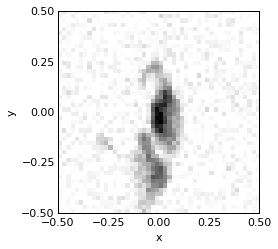

In [52]:
hl.Image(t[1,:].squeeze())

OK, so we've written a dataset that has an iterator that follows the standard Python conventions. Now, all we need to do is get Pylearn2 to accept this dataset. Easiest way to do this is to write it into a YAML file and run a training script. Writing the above into modules in our codebase and using the following YAML file:

In [53]:
!cat yaml_templates/alexnet_based_listdataset.yaml

!obj:pylearn2.train.Train {
    dataset: &train !obj:neukrill_net.image_directory_dataset.ListDataset {
        transformer: !obj:neukrill_net.augment.RandomAugment {
                units: 'float',
                rotate: -1,
                rotate_is_resizable: 0,
                flip: 1,
                resize: %(final_shape)s,
                shunt: 0.075,
                shear: 5
            },
        settings_path: %(settings_path)s,
        run_settings_path: %(run_settings_path)s
    },
    model: !obj:pylearn2.models.mlp.MLP {
        batch_size: &batch_size 128,
        input_space: !obj:pylearn2.space.Conv2DSpace {
            shape: %(final_shape)s,
            num_channels: 1,
            axes: ['b', 0, 1, 'c'],
        },
        layers: [ !obj:pylearn2.models.mlp.ConvRectifiedLinear {
                     layer_name: h1,
                     output_channels: 48,
                     irange: .025,
                     init_bias: 0,
                     kernel_shape: [8, 

Ran the model (many times) updating the code until it would work. Now the above YAML will train.

Bugs?
===

We might have bugs in the ListDataset as when running it with _the same_ augmentations as used in the traditional methods we don't see anywhere near the same performance increases. In fact, it was barely able to learn at all, so it's probably broken somehow. As it can't learn at all, it might be garbling the Images, producing batches that don't correspond to the targets.

The following code checks that we don't have problems with our random number generators:

In [54]:
import neukrill_net.image_directory_dataset

In [55]:
fn = neukrill_net.augment.RandomAugment(**{"units":"float64",
                                           "rotate":[0,90,180,270],
                                           "flip":1,
                                           "rotate_is_resizable":0,
                                           "normalise":{"global_or_pixel":"global",
                                "mu":0.95727,"sigma":0.1423},
                                           "resize":(48,48)
                                           })
fn2 = neukrill_net.augment.RandomAugment(**{"units":"float64",
                                           "rotate":[0,90,180,270],
                                           "flip":1,
                                           "rotate_is_resizable":0,
                                           "normalise":{"global_or_pixel":"global",
                                "mu":0.95727,"sigma":0.1423},
                                           "resize":(48,48)
                                           })

In [56]:
dataset = neukrill_net.image_directory_dataset.ListDataset(fn, force=True)
dataset2 = neukrill_net.image_directory_dataset.ListDataset(fn2, force=True)

In [57]:
iterator = dataset.iterator(batch_size=128)
iterator2 = dataset2.iterator(batch_size=128)

AssertionError: 

> /afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/image_directory_dataset.py(53)__init__()
     52         else:
---> 53             assert mode == 'even_sequential'
     54         # have to add this for checks during training

ipdb> exit


In [ ]:
for a,b in zip(iterator,iterator2):
    if (not np.allclose(a[0],b[0]) or not np.allclose(a[1],b[1])):
        print("Shit.")

In [ ]:
not np.allclose(a[0],b[0])

In [ ]:
not np.allclose(a[0],b[0]) or not np.allclose(a[1],b[1])

Checking Against Dense
-------------------

The DensePNGDataset doesn't appear to have the problems we're seeing with the ListDataset. If we load the _exact same processing_ in both and iterate over the minibatches sequentially we should see _exactly the same_ minibatches being produced.

In [ ]:
reload(neukrill_net.image_directory_dataset)

In [ ]:
dense = neukrill_net.dense_dataset.DensePNGDataset(
                            run_settings=run_settings['run_settings_path'],
                                        force=True, verbose=True)

In [ ]:
run_settings['run_settings_path']

In [ ]:
fn = neukrill_net.augment.RandomAugment(**{"units":"float64",
                                           "normalise":{"global_or_pixel":"global",
                                                "mu":0.95727,"sigma":0.1423},
                                           "resize":(48,48)})

In [ ]:
lists = neukrill_net.image_directory_dataset.ListDataset(fn,
                    run_settings_path=run_settings['run_settings_path'], force=True)

In [ ]:
run_settings = neukrill_net.utils.load_run_settings(
            "run_settings/alexnet_based_runtest.json",settings,
                                                   force=True)
ystring = neukrill_net.utils.format_yaml(run_settings,settings)
train = pylearn2.config.yaml_parse.load(ystring)

In [ ]:
data_specs = train.algorithm.cost.get_data_specs(train.model)

In [ ]:
mapping = DataSpecsMapping(data_specs)
space_tuple = mapping.flatten(data_specs[0], return_tuple=True)
source_tuple =  mapping.flatten(data_specs[1], return_tuple=True)
flat_data_specs = (CompositeSpace(space_tuple), source_tuple)

In [ ]:
dense_iterator = dense.iterator(mode='even_sequential',batch_size=128,
                                data_specs=flat_data_specs,return_tuple=True)

In [ ]:
list_iterator = lists.iterator(mode='sequential',batch_size=128)

In [ ]:
a = dense_iterator.next()
b = list_iterator.next()

In [ ]:
print(a[0].shape,a[1].shape)

In [ ]:
print(b[0].shape,b[1].shape)

Recent tests indicate __it is working after all__, so I'm neglecting these tests.

Hierarchical Models
=======

We want to be able to represent some of taxonomic tree information in the labels, in order to hopefully propagate some more useful information from these additional labels. This amounts to having multiple softmax layers in our output layer. These are wrapped in a FlattenerLayer so expect to see a big n-of-k encoded vector indicator the class and superclasses as targets for every data point.

Unfortunately, we've got some bugs with how this is working, so going to look at how to debug these.

In [ ]:
import neukrill_net.image_directory_dataset

In [ ]:
dataset = neukrill_net.image_directory_dataset.ListDataset(transformer=fn,
    run_settings_path="run_settings/alexnet_based_extra_convlayer_with_superclasses.json",
                                                           force=True)

In [82]:
import neukrill_net.encoding

In [168]:
hier = neukrill_net.encoding.get_hierarchy()

In [169]:
hier

[['acantharia_protist',
  'acantharia_protist_big_center',
  'acantharia_protist_halo',
  'amphipods',
  'appendicularian_fritillaridae',
  'appendicularian_s_shape',
  'appendicularian_slight_curve',
  'appendicularian_straight',
  'artifacts',
  'artifacts_edge',
  'chaetognath_non_sagitta',
  'chaetognath_other',
  'chaetognath_sagitta',
  'chordate_type1',
  'copepod_calanoid',
  'copepod_calanoid_eggs',
  'copepod_calanoid_eucalanus',
  'copepod_calanoid_flatheads',
  'copepod_calanoid_frillyAntennae',
  'copepod_calanoid_large',
  'copepod_calanoid_large_side_antennatucked',
  'copepod_calanoid_octomoms',
  'copepod_calanoid_small_longantennae',
  'copepod_cyclopoid_copilia',
  'copepod_cyclopoid_oithona',
  'copepod_cyclopoid_oithona_eggs',
  'copepod_other',
  'crustacean_other',
  'ctenophore_cestid',
  'ctenophore_cydippid_no_tentacles',
  'ctenophore_cydippid_tentacles',
  'ctenophore_lobate',
  'decapods',
  'detritus_blob',
  'detritus_filamentous',
  'detritus_other',
  '

In [170]:
l = sum([1 for a in hier for b in a])

In [171]:
l

188

In [172]:
sum([len(a) for a in hier])

188

In [173]:
x = settings.classes[1]

In [174]:
class_dictionary = {}
for i,c in enumerate(settings.classes):
    class_dictionary[c] = i

In [175]:
conflicted = []
for x in settings.classes:
    v1 = np.array(neukrill_net.encoding.get_encoding(x,hier)[0])
    v2 = np.zeros(len(settings.classes))
    v2[class_dictionary[x]] = 1
    if not np.allclose(v1,v2):
        print(x)
        conflicted.append(x)

appendicularian_slight_curve
appendicularian_s_shape
hydromedusae_narcomedusae
hydromedusae_narco_young
shrimp_caridean
shrimp-like_other


In [176]:
hier[0] = [str(c) for c in settings.classes]

In [177]:
for x in settings.classes:
    v1 = np.array(neukrill_net.encoding.get_encoding(x,hier)[0])
    v2 = np.zeros(len(settings.classes))
    v2[class_dictionary[x]] = 1
    if not np.allclose(v1,v2):
        print(x)

In [178]:
[np.where(np.array(a)==1)[0][0] for a in neukrill_net.encoding.get_encoding(x,hier)]

[120, 37, 12, 5, 3, 1]

In [179]:
class_dictionary = {}
for c in hier[0]:
    class_dictionary[c] = np.where(np.array([a 
                           for l in neukrill_net.encoding.get_encoding(c,hier)
                           for a in l])==1)[0]

In [180]:
class_dictionary

{'acantharia_protist': array([  0, 121, 172, 180, 185, 187]),
 'acantharia_protist_big_center': array([  1, 121, 172, 180, 185, 187]),
 'acantharia_protist_halo': array([  2, 121, 172, 180, 185, 187]),
 'amphipods': array([  3, 126, 161, 176, 182, 187]),
 'appendicularian_fritillaridae': array([  4, 122, 170, 177, 183, 187]),
 'appendicularian_s_shape': array([  6, 122, 170, 177, 183, 187]),
 'appendicularian_slight_curve': array([  5, 122, 170, 177, 183, 187]),
 'appendicularian_straight': array([  7, 122, 170, 177, 183, 187]),
 'artifacts': array([  8, 138, 168, 178, 184, 186]),
 'artifacts_edge': array([  9, 138, 168, 178, 184, 186]),
 'chaetognath_non_sagitta': array([ 10, 125, 171, 180, 185, 187]),
 'chaetognath_other': array([ 11, 125, 171, 180, 185, 187]),
 'chaetognath_sagitta': array([ 12, 125, 171, 180, 185, 187]),
 'chordate_type1': array([ 13, 143, 171, 180, 185, 187]),
 'copepod_calanoid': array([ 14, 123, 160, 175, 182, 187]),
 'copepod_calanoid_eggs': array([ 15, 123, 16

In [181]:
y = np.zeros((len(settings.classes),188))

In [182]:
for i,j in enumerate(map(lambda c: class_dictionary[c],settings.classes)):
    y[i,j] = 1
    print(i,j)

(0, array([  0, 121, 172, 180, 185, 187]))
(1, array([  1, 121, 172, 180, 185, 187]))
(2, array([  2, 121, 172, 180, 185, 187]))
(3, array([  3, 126, 161, 176, 182, 187]))
(4, array([  4, 122, 170, 177, 183, 187]))
(5, array([  5, 122, 170, 177, 183, 187]))
(6, array([  6, 122, 170, 177, 183, 187]))
(7, array([  7, 122, 170, 177, 183, 187]))
(8, array([  8, 138, 168, 178, 184, 186]))
(9, array([  9, 138, 168, 178, 184, 186]))
(10, array([ 10, 125, 171, 180, 185, 187]))
(11, array([ 11, 125, 171, 180, 185, 187]))
(12, array([ 12, 125, 171, 180, 185, 187]))
(13, array([ 13, 143, 171, 180, 185, 187]))
(14, array([ 14, 123, 160, 175, 182, 187]))
(15, array([ 15, 123, 160, 175, 182, 187]))
(16, array([ 16, 123, 160, 175, 182, 187]))
(17, array([ 17, 123, 160, 175, 182, 187]))
(18, array([ 18, 123, 160, 175, 182, 187]))
(19, array([ 19, 123, 160, 175, 182, 187]))
(20, array([ 20, 123, 160, 175, 182, 187]))
(21, array([ 21, 123, 160, 175, 182, 187]))
(22, array([ 22, 123, 160, 175, 182, 187])

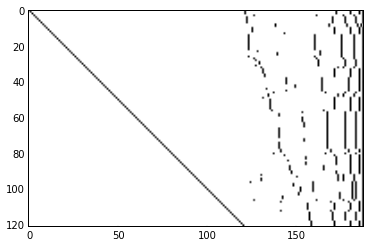

In [183]:
plt.imshow(y,cmap='Greys')

In [134]:
hier = neukrill_net.encoding.get_hierarchy()

In [135]:
class_dictionary2 = {}
for c in hier[0]:
    class_dictionary2[c] = np.where(np.array([a 
                           for l in neukrill_net.encoding.get_encoding(c,hier)
                           for a in l])==1)[0]

In [161]:
yb = np.zeros((len(settings.classes),188))

In [166]:
for i,j in enumerate(map(lambda c: class_dictionary2[c],settings.classes)):
    yb[i,j] = 1

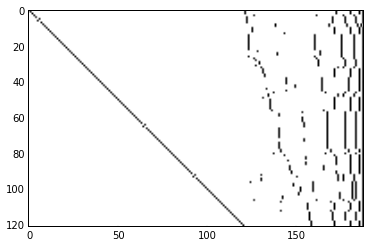

In [167]:
plt.imshow(yb,cmap='Greys')

In [132]:
np.allclose(y[121:],yb[121:])

True

In [184]:
for c in conflicted:
    print(c,class_dictionary[c],class_dictionary2[c])

(u'appendicularian_slight_curve', array([  5, 122, 170, 177, 183, 187]), array([  6, 122, 170, 177, 183, 187]))
(u'appendicularian_s_shape', array([  6, 122, 170, 177, 183, 187]), array([  5, 122, 170, 177, 183, 187]))
(u'hydromedusae_narcomedusae', array([ 64, 154, 167, 177, 183, 187]), array([ 65, 154, 167, 177, 183, 187]))
(u'hydromedusae_narco_young', array([ 65, 154, 167, 177, 183, 187]), array([ 64, 154, 167, 177, 183, 187]))
(u'shrimp_caridean', array([ 92, 130, 173, 176, 182, 187]), array([ 93, 130, 173, 176, 182, 187]))
(u'shrimp-like_other', array([ 93, 150, 173, 176, 182, 187]), array([ 92, 150, 173, 176, 182, 187]))


In [187]:
oldy = y[:]

Check for Heisenbugs:

In [189]:
for _ in range(100):
    y = np.zeros((len(settings.classes),188))
    for i,j in enumerate(map(lambda c: class_dictionary[c],settings.classes)):
        y[i,j] = 1
    if not np.allclose(y,oldy):
        print("Arrays do not match.")
    oldy = y[:]

In [213]:
reload(neukrill_net.encoding)

<module 'neukrill_net.encoding' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/encoding.py'>

In [214]:
hierarchy = neukrill_net.encoding.get_hierarchy(settings)

In [215]:
for i,j in zip(settings.classes,hierarchy[0]):
    if i != j:
        print(i,j)

In [216]:
class_dictionary = neukrill_net.encoding.make_class_dictionary(settings.classes,hierarchy)

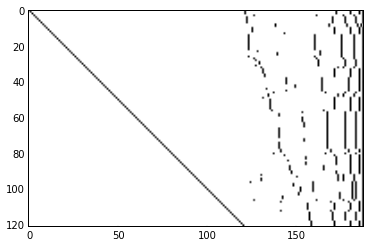

In [218]:
y = np.zeros((len(settings.classes),188))
for i,j in enumerate(map(lambda c: class_dictionary[c],hierarchy[0])):
    y[i,j] = 1
plt.imshow(y,cmap='Greys')